# Package importing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import pickle
import gc
import math

from learning.cva_estimator_portfolio_int_pl import CVAEstimatorPortfolioInt
from learning.misc import batch_mean
from simulation.diffusion_engine_pl import DiffusionEngine

In [2]:
from numba import NumbaPerformanceWarning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=NumbaPerformanceWarning)

In [3]:
def open_pickle(name):
    with open('./'+name+'.pickle', 'rb') as f:
         return pickle.load(f)

def save_pickle(name,data):
    with open('./'+name+'.pickle', 'wb') as f:
        pickle.dump(data, f)

In [4]:
np.random.seed(0)
torch.manual_seed(0)

# Set seed for diffusion paths and random parameter paths
diffusion_seed = 1  #+10 for train, +20 for test, any for parameter randomization
parameter_shock_seed = 9 

In [5]:
torch.backends.cudnn.benchmark = False # don't allow cudnn to tune for every input size
torch.backends.cudnn.enabled = True

In [6]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Simulation parameters

* `T`: portfolio maturity;
* `num_coarse_steps`: # of coarse time-steps, *ie* steps at which we price and learn;
* `dT`: size of a coarse time-step (uniform time-stepping), should be equal to the simulation horizon in years divided by `num_coarse_steps`;
* `num_fine_per_coarse`: # of fine time-steps per coarse time-step, those are steps through which the numerical diffusions are stepping;
* `dt`: should be equal to `dT/num_fine_per_coarse`;
* `num_paths`: # of diffusion paths ($M$ in \[1\]);
* `num_inner_paths`: # of inner-paths for the Nested Monte Carlo benchmark, set to `1` if no NMC benchmark is needed;
* `num_defs_per_path`: # of default simulations given each diffusion path ($N$ in \[1\]);
* `num_rates`: # of economies, each represented by a 1-factor short-rate;
* `num_spreads`: # of counterparties + 1, with one stochastic spread for each counterparty and one for the bank itself;
* `R`: correlation matrix, should be `2*num_rates-1+num_spreads` by `2*num_rates-1+num_spreads`;

As for the order in which the stochastic diffusion factors are stored, the first `num_rates` components are the short-rates, the next `num_rates-1` are the associated cross-currency exchange rates against the reference currency (which is assumed to be the first, *ie* with id 0), and the last `num_spreads` are the stochastic intensity processes where the first one is for the bank and the rest are for the counterparties.

As for the diffusion parameters, they can be set using the following correspondence with the notation in Appendix B of \[1\]:
* `rates_params['a'][e]` $\leftrightarrow a^{\langle e\rangle}$;
* `rates_params['b'][e]` $\leftrightarrow b^{\langle e\rangle}$;
* `rates_params['sigma'][e]` $\leftrightarrow \sigma^{r, \langle e\rangle}$;
* `fx_params['vol'][e]` $\leftrightarrow \sigma^{\chi, \langle e\rangle}$;
* `spreads_params['a'][c]` $\leftrightarrow \alpha^{\langle c\rangle}$;
* `spreads_params['b'][c]` $\leftrightarrow \delta^{\langle c\rangle}$;
* `spreads_params['vvol'][c]` $\leftrightarrow \nu^{\langle c\rangle}$;

Finally, for the products, one can set them in their `specs` arrays below. We invite the user to see the pricing functions in `compile_cuda_diffuse_and_price` (simulation/kernels.py) for more details on how the product specifications are used.

In the following, we fill the diffusion parameters and the product specs randomly.

**\[1\]** Abbas-Turki, L., S. Crépey, and B. Saadeddine (2023).  Pathwise CVA regressions with oversimulated defaults. Mathematical Finance 33(2), pages 274-307, 2023.

In [7]:
np.random.seed(0)
torch.manual_seed(0)

T = 10
num_coarse_steps = 100
dT = T/num_coarse_steps
num_fine_per_coarse = 25
dt = T/num_coarse_steps/num_fine_per_coarse

num_fine_steps = num_coarse_steps*num_fine_per_coarse

num_paths = 2**17
num_inner_paths = 1024#512
num_defs_per_path = 1 #256

num_rates = 10
num_spreads = 9
R = np.eye(2*num_rates-1+num_spreads, dtype=np.float32) # we set the correlation matrix to the identity matrix, although not needed
initial_values = np.empty(2*num_rates-1+num_spreads, dtype=np.float32)
initial_defaults = np.empty((num_spreads-1+7)//8, dtype=np.int8)

# rates diffusion parameters
rates_params = np.empty(num_rates, dtype=[('a', '<f4'), ('b', '<f4'), ('sigma', '<f4')])
rates_params['a'] = np.random.normal(0.5, 0.05, num_rates).round(4)
rates_params['b'] = np.random.normal(0.03, 0.003, num_rates).round(4)
rates_params['sigma'] = np.abs(np.random.normal(0.01, 0.001, num_rates)).round(4)
initial_values[:num_rates] = 0.01

# FX diffusion parameters
fx_params = np.empty(num_rates-1, dtype=[('vol', '<f4')])
fx_params['vol'] = np.abs(np.random.normal(0.5, 0.05, num_rates-1)).round(4)
initial_values[num_rates:2*num_rates-1] = 1

# stochastic intensities diffusion parameter7
spreads_params = np.empty(num_spreads, dtype=[('a', '<f4'), ('b', '<f4'), ('vvol', '<f4')])
spreads_params['a'] = np.random.normal(0.7, 0.07, num_spreads)
spreads_params['b'] = np.random.normal(0.04, 0.004, num_spreads)
spreads_params['vvol'] = np.abs(np.random.normal(0.1, 0.01, num_spreads))
initial_values[2*num_rates-1:] = 0.015

# initial default indicators
initial_defaults[:] = 0

# length of simulated path on the GPU (paths are then simulated by chunks of cDtoH_freq until maturity)
cDtoH_freq = 64 # 20

# product specs (DO NOT use the ZCs)
num_vanillas = 0#500 if portfolio == 'call' else 0
vanilla_specs = np.empty(num_vanillas,
                            dtype=[('maturity', '<f4'), ('notional', '<f4'),
                                ('strike', '<f4'), ('cpty', '<i4'),
                                ('undl', '<i4'), ('call_put', '<b1')])
vanilla_specs['maturity'] = np.random.uniform(0.1,9.5,num_vanillas)
vanilla_specs['notional'] = 1000. *     ((np.random.choice((-1, 1), num_vanillas, p=(0.5, 0.5)))
        * np.random.choice(range(1, 6), num_vanillas))
vanilla_specs['strike'] = abs(1. * np.random.uniform(0.9,1.1, num_vanillas))
vanilla_specs['cpty'] = np.random.randint(0, num_spreads-1, num_vanillas, np.int32)  # Counterparty with which the swap was entered into
#vanilla_specs['undl'] = np.random.randint(0, num_rates-1, num_vanillas, np.int32)  # Underlying currency
vanilla_specs['undl'] = np.random.randint(0, num_rates-1, num_vanillas, np.int32)  # Underlying currency
vanilla_specs['call_put'] = np.random.choice((True, False), num_vanillas, p=(0.5, 0.5))

num_irs = 500
irs_specs = np.empty(num_irs,
                     dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'),
                            ('notional', '<f4'), ('swap_rate', '<f4'),
                            ('num_resets', '<i4'), ('cpty', '<i4'),
                            ('undl', '<i4')])

irs_specs['first_reset'] = 0.  # First reset date in the swaps
irs_specs['reset_freq'] = 75*dt # 0.2  # Reset frequency
irs_specs['notional'] = 10000. *  ((np.random.choice((-1, 1), num_irs, p=(0.5, 0.5))) * np.random.choice(range(1, 11), num_irs)).round(4)  # Notional of the swaps
irs_specs['swap_rate'] = np.abs(np.random.normal(0.03, 0.001, num_irs)).round(4)  # Swap rate. To be overwritten in the ATM swaps case
irs_specs['num_resets'] = np.random.randint(int((1+dt)/(75*dt)), num_fine_steps//75+1, num_irs, np.int32) # Number of resets (num_resets*reset_freq should be equal to the desired maturity)
irs_specs['cpty'] = np.random.randint(0, num_spreads-1, num_irs, np.int32)  # Counterparty with which the swap was entered into
irs_specs['undl'] = np.random.randint(0, num_rates, num_irs, np.int32)  # Underlying currency

num_zcs = 0
zcs_specs = np.empty(num_zcs, 
                     dtype=[('maturity', '<f4'), ('notional', '<f4'),
                            ('cpty', '<i4'), ('undl', '<i4')])

                            

In [8]:
initial_g_diff_params = np.concatenate([pd.DataFrame(rates_params).to_numpy().T.ravel(),pd.DataFrame(fx_params).to_numpy().T.ravel(),
                                        np.zeros(num_rates-1), pd.DataFrame(spreads_params).to_numpy().T.ravel()], dtype= np.float32).T
num_diff = initial_values.size
num_para = initial_g_diff_params.size + initial_values.size
'''
g1 = np.delete(np.arange(num_diff), 2*num_rates-1)
g2 = np.arange(num_diff, num_diff + num_rates)
g3 = np.arange(num_diff+ num_rates, num_diff + 2*num_rates)
g4 = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates)
g4 = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates)
g5 = np.arange(num_diff+ 3*num_rates, num_diff + 4*num_rates-1)
g6 = np.arange(num_diff+ 5*num_rates-1, num_diff+ 5*num_rates-1+num_spreads-1)
g7 = np.arange(num_diff+ 5*num_rates-1+num_spreads, num_diff+ 5*num_rates-1+2*num_spreads-1)
g8 = np.arange(num_diff+ 5*num_rates-1+2*num_spreads, num_diff+ 5*num_rates-1+3*num_spreads-1)
'''

'\ng1 = np.delete(np.arange(num_diff), 2*num_rates-1)\ng2 = np.arange(num_diff, num_diff + num_rates)\ng3 = np.arange(num_diff+ num_rates, num_diff + 2*num_rates)\ng4 = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates)\ng4 = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates)\ng5 = np.arange(num_diff+ 3*num_rates, num_diff + 4*num_rates-1)\ng6 = np.arange(num_diff+ 5*num_rates-1, num_diff+ 5*num_rates-1+num_spreads-1)\ng7 = np.arange(num_diff+ 5*num_rates-1+num_spreads, num_diff+ 5*num_rates-1+2*num_spreads-1)\ng8 = np.arange(num_diff+ 5*num_rates-1+2*num_spreads, num_diff+ 5*num_rates-1+3*num_spreads-1)\n'

Next, we select the GPU. This is where both the simulation and the training/inference are going to be performed.

In [9]:
device = torch.device('cuda:0')

num_steps_per_reset = int((irs_specs['reset_freq'][0]+dt)/(dT))
prev_reset_arr = (np.arange(num_coarse_steps+1+1)-1)//num_steps_per_reset*num_steps_per_reset
#prev_reset_arr = (np.arange(num_coarse_steps+1+1)-1)//2*2

# CVA baseline mode simulation 

We then instantiate the diffusion engine and the estimators (one with default indicators and the other with default intensities).
Adding one early pricing date $t=0.01.$

In [92]:
diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                           num_paths, 1, num_defs_per_path, 
                                           num_rates, num_spreads, R, rates_params, fx_params, 
                                           spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                           initial_values, initial_defaults, cDtoH_freq, device.index,
                                           pathwise_diff_para =  np.zeros((num_para,num_paths), dtype = np.float32),
                                           early_pricing_date =[0.01], seed = diffusion_seed)

Successfully compiled all kernels.
Randomizing diffusion parameters.


In [93]:
with torch.cuda.device(device):
    _evt_start = torch.cuda.Event(enable_timing=True)
    _evt_stop = torch.cuda.Event(enable_timing=True)

In [94]:
cva_estimator = CVAEstimatorPortfolioInt(prev_reset_arr, True, False, False, False, 
                                         diffusion_engine, device, 2, 2*(num_rates+num_spreads), 
                                           (num_paths*num_defs_per_path)//8, 
                                           100, 0.01, 0, reset_weights=False, linear=False, 
                                           best_sol=True, refine_last_layer=True)

In [95]:
_evt_start.record()
diffusion_engine.reset_rng_states(diffusion_seed)
diffusion_engine.generate_batch(fused=True, set_irs_at_par=True, time_to_change_seed= np.inf, seed_to_change=20)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)
print('Everything done in {} ms'.format(round(elapsed_time_def, 3)))

cuda_diffuse_and_price elapsed time: 3462.082 ms
Everything done in 3936.77 ms


Save diffusive risk factors and ATM interest rate specifications. 

In [96]:
baseline_diffusion_X = diffusion_engine.X.copy()
ATM_irs_specs = diffusion_engine.irs_specs.copy()

Simulate one more time without reinstantiating the diffusion engine

In [97]:
_evt_start.record()
diffusion_engine.reset_rng_states(diffusion_seed + 10) # use it for better control the seed
diffusion_engine.generate_batch(fused=True, nested_cva_at=None, indicator_in_cva=False, set_irs_at_par=False)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)
print('Simulation done in {} ms'.format(round(elapsed_time_def, 3)))

cuda_diffuse_and_price elapsed time: 3448.437 ms
Simulation done in 3852.39 ms


In [98]:
timesteps = range(num_coarse_steps+1, -1, -1)
xi_baseline = np.empty((num_coarse_steps+1+1, num_defs_per_path*num_paths,1), dtype=np.float32)
cva_label_gen = cva_estimator._build_labels()
for t in timesteps:
    xi_baseline[t] = next(cva_label_gen)
CVA_base0 = xi_baseline[0].mean()

In [101]:
del diffusion_engine, cva_estimator
torch.cuda.empty_cache()
gc.collect()

378114

# CVA risk mode simulation

In [17]:
time_horizon_index = [1,2,11] 

# New time steps with early pricing date are:
# 0 0.01 0.1 0.2... 1

In [43]:
def parameter_shock_generator(idx_horizon, para_shock_seed = parameter_shock_seed): 
    
    #shock generation
    time_horizon_value = np.concatenate([np.array([0,1]),np.arange(10,1010,10)])
    pathwise_diff_params = np.random.RandomState(para_shock_seed).multivariate_normal(np.zeros(num_para), np.eye(num_para), size = (num_paths))
    
    shock_train = math.sqrt(time_horizon_value[idx_horizon])*0.01*np.array(pathwise_diff_params, dtype = np.float32).T
    
    pathwise_diff_params = np.random.RandomState(para_shock_seed + 111).multivariate_normal(np.zeros(num_para), np.eye(num_para), size = (num_paths))
    shock_test = math.sqrt(time_horizon_value[idx_horizon])*0.01*np.array(pathwise_diff_params, dtype = np.float32).T
    
    shock_train[0:num_diff, :] = 0
    shock_test[0:num_diff, :] = 0
    
    return shock_train, shock_test


def payoff_CVA_risk_simulation(idx_horizon, shock_para, seed_dif, num_inner_paths_ = 1): # Y0_projection = 'gau', 'baseline', 'sensis'
    

    diffusion_engine_risk = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                               num_paths, num_inner_paths_, num_defs_per_path, 
                                               num_rates, num_spreads, R, rates_params, fx_params, 
                                               spreads_params, vanilla_specs, ATM_irs_specs, zcs_specs,
                                               initial_values, initial_defaults, cDtoH_freq, device.index,
                                               pathwise_diff_para =  shock_para.copy(),
                                               early_pricing_date =[0.01], seed = diffusion_seed+ seed_dif)
    
    
    with torch.cuda.device(device):
        _evt_start = torch.cuda.Event(enable_timing=True)
        _evt_stop = torch.cuda.Event(enable_timing=True)
    
    cva_estimator_risk = CVAEstimatorPortfolioInt(prev_reset_arr, True, False, False, True,
                                         diffusion_engine_risk, device, 2, 2*(num_rates+num_spreads), 
                                           (num_paths*num_defs_per_path)//16, 
                                           100, 0.01, 0, reset_weights=False, 
                                           best_sol=True, refine_last_layer=True)
    

    
    _evt_start.record()
    diffusion_engine_risk.reset_rng_states(diffusion_seed + seed_dif) # use it for better control the seed
    diffusion_engine_risk.generate_batch(fused=True, nested_cva_at=[idx_horizon] if num_inner_paths_>1 else None, 
                                         indicator_in_cva=False, set_irs_at_par=False)
    _evt_stop.record()
    _evt_stop.synchronize()
    elapsed_time_def = _evt_start.elapsed_time(_evt_stop)
    print('Simulation done in {} ms'.format(round(elapsed_time_def, 3)))
    
    xi = np.empty(( num_defs_per_path*num_paths,1), dtype=np.float32)

    timesteps = range(num_coarse_steps+1, -1, -1)
    cva_label_gen = cva_estimator_risk._build_labels()
    for t in timesteps:
        if t == idx_horizon:
            xi = next(cva_label_gen)
        else:
            next(cva_label_gen)
    
    
    lgd_risk = np.empty(shape=([ num_paths * num_defs_per_path, 1]), dtype = np.float32)
    
    fea = np.empty(shape=(idx_horizon+1, num_paths , cva_estimator_risk.num_features + cva_estimator_risk.num_params * cva_estimator_risk.include_para_as_fea), dtype = np.float32)

    def_ind = np.empty(shape=(idx_horizon+1, num_paths * num_defs_per_path, 8), dtype = np.float32)
    
    features_gen_risk = cva_estimator_risk._features_generator()
    
    for t in range(idx_horizon+1):
        next(features_gen_risk)
        feature0 = features_gen_risk.send(t)

        with torch.no_grad():
            for j, feature_batch in enumerate(feature0()):
                
                def_ind[t, j*cva_estimator_risk.batch_size:(j + 1)*cva_estimator_risk.batch_size] = feature_batch.cpu().numpy()[:,37:45]
    
                if num_paths<=cva_estimator_risk.batch_size and j ==0:
                    fea[ t, j*cva_estimator_risk.batch_size:(j + 1)*cva_estimator_risk.batch_size] = feature_batch.cpu().numpy()[:num_paths]
                elif (j + 1)*cva_estimator_risk.batch_size<=num_paths:
                    fea[ t, j*cva_estimator_risk.batch_size:(j + 1)*cva_estimator_risk.batch_size] = feature_batch.cpu().numpy()
                      

    inst_def_ind = def_ind.copy()

    for i in range(1,len(def_ind)):
        inst_def_ind[i] = def_ind[i]- def_ind[i-1]


    lgd = np.zeros((idx_horizon+1, num_paths * num_defs_per_path), dtype = np.float32)
    mtm_ = np.tile(diffusion_engine_risk.mtm_by_cpty[0], num_defs_per_path).T

    lgd[1]= (inst_def_ind[1]*np.maximum(mtm_,0)).sum(axis = 1)
    lgd[1] *= np.exp(-np.tile(diffusion_engine_risk.dom_rate_integral[1], num_defs_per_path))

    for t in range(2,idx_horizon+1):
        tt = t-2 if t ==2 else t-1 # due to the early pricing date
        mtm_ = np.tile(diffusion_engine_risk.mtm_by_cpty[tt], num_defs_per_path).T
        lgd[t] = (inst_def_ind[t]*np.maximum(mtm_,0)).sum(axis = 1)
        lgd[t] *= np.exp(-np.tile(diffusion_engine_risk.dom_rate_integral[t], num_defs_per_path))

    lgd[1:] = lgd[1:].cumsum(axis =0)
    
    lgd_risk = lgd[idx_horizon][:,np.newaxis]
        
    dc_factor  = np.exp(-np.tile(diffusion_engine_risk.dom_rate_integral[0:idx_horizon+1,:], num_defs_per_path)[:,:,np.newaxis])
    
    
    nested = diffusion_engine_risk.nested_cva[idx_horizon].reshape(-1,1) 
    
    del  diffusion_engine_risk, cva_estimator_risk, cva_label_gen, feature0
    torch.cuda.empty_cache()
    gc.collect()
    

    return (fea, lgd_risk, 
            inst_def_ind, dc_factor,
            nested, xi)

def two_ind_paths_generator(idx_horizon, shock_para, seed_dif, change_seed = True): # Y0_projection = 'gau', 'baseline', 'sensis'
    real_time = np.concatenate([np.array([0,1]),np.arange(10,1010,10)])/100
    twin_y12 = np.empty(shape=( 2, num_paths ,1))
    diffusion_engine_risk = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                               num_paths, 1, num_defs_per_path, 
                                               num_rates, num_spreads, R, rates_params, fx_params, 
                                               spreads_params, vanilla_specs, ATM_irs_specs, zcs_specs,
                                               initial_values, initial_defaults, cDtoH_freq, device.index, 
                                               pathwise_diff_para =  shock_para.copy(),
                                               early_pricing_date =[0.01], seed = diffusion_seed+ seed_dif)
    
    cva_estimator_risk = CVAEstimatorPortfolioInt(prev_reset_arr, True, False, False, True,
                                         diffusion_engine_risk, device, 2, 2*(num_rates+num_spreads), 
                                           (num_paths*num_defs_per_path)//16, 
                                           100, 0.01, 0, reset_weights=False, 
                                           best_sol=True, refine_last_layer=True)
    
    diffusion_engine_risk.reset_rng_states(diffusion_seed + seed_dif) # use it for better control the seed
    diffusion_engine_risk.generate_batch(fused=True, nested_cva_at=[idx_horizon], indicator_in_cva=False, set_irs_at_par=False,
                                           time_to_change_seed=real_time[idx_horizon] if change_seed else np.inf, seed_to_change=diffusion_seed+ seed_dif + 100)
    
    twin_y12[0] = diffusion_engine_risk.nested_cva[idx_horizon].reshape(-1,1)    
    
    diffusion_engine_risk.reset_rng_states(diffusion_seed + seed_dif) # use it for better control the seed
    diffusion_engine_risk.generate_batch(fused=True, nested_cva_at=[idx_horizon], indicator_in_cva=False, set_irs_at_par=False,
                                           time_to_change_seed=real_time[idx_horizon] if change_seed else np.inf , seed_to_change=diffusion_seed+ seed_dif + 200)
  
    twin_y12[1] = diffusion_engine_risk.nested_cva[idx_horizon].reshape(-1,1)    
   
    
    del  diffusion_engine_risk, cva_estimator_risk
    torch.cuda.empty_cache()
    gc.collect()
    

    return twin_y12

In [ ]:
from tqdm import tqdm
features_risk, LGD_risk, instant_def_ind_risk, dc_factor_risk, nested_risk,  twin_y12_risk, xi_risk =  list(), list(),list(),list(),list(),list(),list()
for h in tqdm(time_horizon_index):
    shock_train, shock_test = parameter_shock_generator(h, parameter_shock_seed)
    res_train = payoff_CVA_risk_simulation(h, shock_train, 10, 1) 
    res_test = payoff_CVA_risk_simulation(h, shock_test, 20, num_inner_paths) 
    res_twin = two_ind_paths_generator(h, shock_test, 20, True)

    features_risk.append(np.asarray([res_train[0], res_test[0]]))
    LGD_risk.append([res_train[1], res_test[1]])
    instant_def_ind_risk.append(np.asarray([res_train[2], res_test[2]]))
    dc_factor_risk.append(np.asarray([res_train[3], res_test[3]]))
    nested_risk.append( res_test[4])
    
    xi_risk.append([res_train[5], res_test[5]])
    
    twin_y12_risk.append(res_twin)

LGD_risk = np.asarray(LGD_risk)
nested_risk = np.asarray(nested_risk)
xi_risk = np.asarray(xi_risk)
twin_y12_risk = np.asarray(twin_y12_risk)

  0%|                                                   | 0/3 [00:00<?, ?it/s]

Successfully compiled all kernels.
Randomizing diffusion parameters.
cuda_diffuse_and_price elapsed time: 3456.267 ms
Simulation done in 3857.706 ms
Successfully compiled all kernels.
Randomizing diffusion parameters.
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
cuda_diffuse_and_price elapsed time: 3438.888 ms
cuda_nested_cva average elapsed time per launch: 1731882.703 ms
Simulation done in 1794058.125 ms
Successfully compiled all kernels.
Randomizing diffusion parameters.
cuda_diffuse_and_price elapsed time: 3653.759 ms
cuda_nested_cva average elapsed time per launch: 88874.057 ms
cuda_diffuse_and_price elapsed time: 3451.877 ms
cuda_nested_cva average elapsed time per launch: 88923.45 ms


 33%|█████████████                          | 1/3 [34:30<1:09:00, 2070.07s/it]

Successfully compiled all kernels.
Randomizing diffusion parameters.
cuda_diffuse_and_price elapsed time: 3460.516 ms
Simulation done in 3864.791 ms
Successfully compiled all kernels.
Randomizing diffusion parameters.
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
cuda_diffuse_and_price elapsed time: 3623.786 ms
cuda_nested_cva average elapsed time per launch: 1703728.705 ms
Simulation done in 1776304.125 ms
Successfully compiled all kernels.
Randomizing diffusion parameters.
opsss
cuda_diffuse_and_price elapsed time: 3632.863 ms
cuda_nested_cva average elapsed time per launch: 87868.255 ms
cuda_diffuse_and_price elapsed time: 3455.602 ms
cuda_nested_cva average elapsed time per launch: 87884.867 ms


 67%|██████████████████████████             | 2/3 [1:08:44<34:20, 2060.90s/it]

Successfully compiled all kernels.
Randomizing diffusion parameters.
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
cuda_diffuse_and_price elapsed time: 3453.552 ms
Simulation done in 3854.83 ms
Successfully compiled all kernels.
Randomizing diffusion parameters.
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss
opsss


In [81]:
LGD_risk_train = LGD_risk[:,0,:,:]
LGD_risk_test = LGD_risk[:,1,:,:]

xi_risk_train = xi_risk[:,0,:,:]
xi_risk_test = xi_risk[:,1,:,:]

features_risk_train = [d[0,:,:,:] for d in features_risk]
features_risk_test = [d[1,:,:,:] for d in features_risk]

instant_def_ind_risk_train = [d[0,:,:,:] for d in instant_def_ind_risk]
instant_def_ind_risk_test = [d[1,:,:,:] for d in instant_def_ind_risk]

dc_factor_risk_train = [d[0,:,:,:] for d in dc_factor_risk]
dc_factor_risk_test = [d[1,:,:,:] for d in dc_factor_risk]

In [110]:
nested_risk.shape

(3, 131072, 1)

The output results:
- `features_risk_train[horizon][timesteps up to horizon, paths, num_features]`: features encomprass diffusive risk factors and parameters
- `instant_def_ind_risk_train[horizon][timesteps up to horizon, paths, num_features]`: the moment when the counterparty defaults occur
- `dc_factor_risk_train[horizon][timesteps up to horizon, paths, num_features]`: discount factor from 0 to risk horizon
- `xi_risk_train[horizon, paths, 1]`:  payoff in the risk mode
- `LGD_risk_train[horizon, paths, 1]`:  LGD in the risk mode
- `nested_risk[horizon, paths, 1]`: nested CVA in the risk mode only on the test data
- `twin_y12_risk[horizon, 2, paths, 1]`: payoff y1 and y2 in the risk mode for the twin Monte Carlo validation only on the test data.




## CVA$_{t}$  learning (run-off)

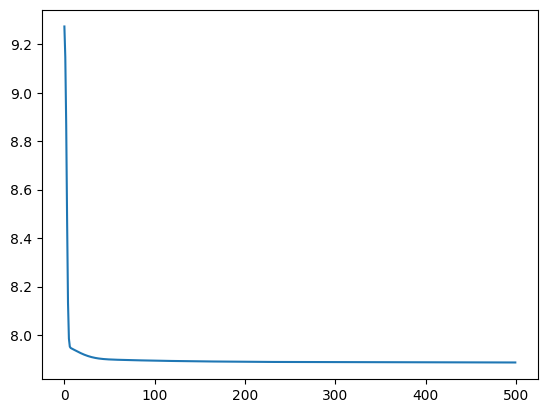

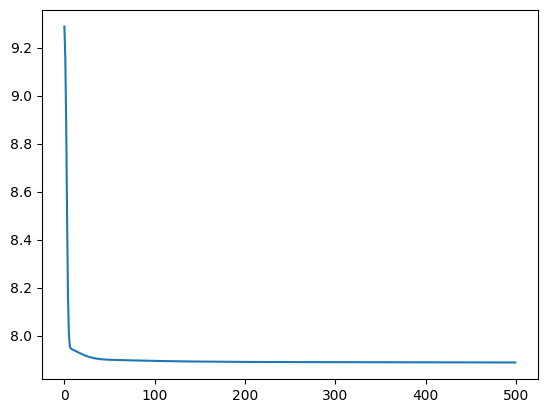

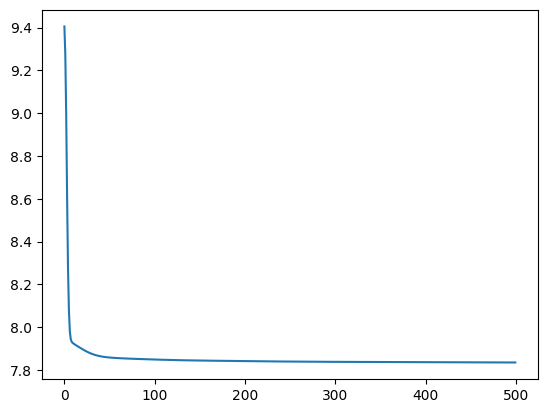

In [82]:
CVA_nn_train = list()
CVA_nn_test = list()


from learning.generic_estimator import GenericModel

criterion = torch.nn.MSELoss(reduction='mean')
num_batch = 32
batch_size = num_paths//num_batch

for j in range(len(xi_risk)):

    label = torch.tensor(xi_risk_train[j], dtype = torch.float32).to(device)
    std_label = label.std()+1e-7
    features_torch = torch.tensor(features_risk_train[j][-1], dtype = torch.float32).to(device)
    features_torch_test = torch.tensor(features_risk_test[j][-1], dtype = torch.float32).to(device)
    
    features_torch_mean = features_torch.mean(axis = 0,keepdim = True)
    features_torch_std = features_torch.std(axis = 0,keepdim = True)+1e-7
    
    model = GenericModel(features_torch.shape[1], 1, 200, 'mean').to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-2)

    model.train()
    losses = []
    for _ in range(500):
        for i in range(num_batch):
            features_batch = features_torch[i*batch_size:(i+1)*batch_size]
            label_batch = label[i*batch_size:(i+1)*batch_size]
            pred = model((features_batch-features_torch_mean)/features_torch_std)
            loss = criterion(pred, label_batch)/std_label
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    model.eval()
    plt.plot(np.log(losses))
    plt.show()
    
    with torch.no_grad():
        pred_train = model((features_torch-features_torch_mean)/features_torch_std).cpu().numpy()
        pred_test = model((features_torch_test-features_torch_mean)/features_torch_std).cpu().numpy() 
    
        CVA_nn_train.append( pred_train)
        CVA_nn_test.append( pred_test)
CVA_nn_train = np.asarray(CVA_nn_train, dtype = np.float32)   
CVA_nn_test = np.asarray(CVA_nn_test, dtype = np.float32)   

Remove some unchanged features

In [87]:
idx_features_risk = np.concatenate([np.arange(27), np.arange(45, features_torch.shape[1]), np.arange(37,45)])

features_baseline0 = np.concatenate([initial_values[:-1], initial_g_diff_params, np.zeros(8)]).reshape(1,-1)

features_risk_train = [d[:,:,idx_features_risk] for d in features_risk_train] 
features_risk_test = [d[:,:,idx_features_risk] for d in features_risk_test] 


Save features, CVA learnt by neural network models, nested CVA and two extra paths for twin Monte Carlo validation

In [116]:
d = {}

d['features_baseline0'] = features_baseline0

d['features_risk_train'] = features_risk_train
d['features_risk_test'] = features_risk_test

d['LGD_risk_train'] = LGD_risk_train
d['LGD_risk_test'] = LGD_risk_test

d['xi_risk_train'] = xi_risk_train
d['xi_risk_test'] = xi_risk_test

d['CVA_nn_train'] = CVA_nn_train
d['CVA_nn_test'] = CVA_nn_test

d['instant_def_ind_risk_train'] = instant_def_ind_risk_train
d['instant_def_ind_risk_test'] = instant_def_ind_risk_test

d['dc_factor_risk_train'] = dc_factor_risk_train
d['dc_factor_risk_test'] = dc_factor_risk_test

d['nested_risk'] = nested_risk
d['twin_y12_risk'] = twin_y12_risk
d['CVA_0'] = CVA_base0

save_pickle('data_for_run-off_analysis', d)
